# Start

In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import os
from matplotlib.cm import get_cmap
import seaborn as sns
import random

In [2]:
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [66]:
df = pd.read_csv('drive/My Drive/dance/data/ble_data.csv')


In [67]:
(df.shape, df['vehicle_id'].nunique(), df['battery_serial_number'].nunique())

((3215664, 29), 7309, 76427)

In [68]:
plt.style.use('seaborn')

<ipython-input-68-4a43041a1d49>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Data Cleaning

In [69]:
## data cleaning general

# remove duplicates
df = df.drop_duplicates()

# drop NAs in mileage
df = df.dropna(subset=['total_mileage'])

# sort based on time
df = df.sort_values(by=['vehicle_id','occurred_at_time'])

# adjust datatype
df['occurred_at_time'] = pd.to_datetime(df['occurred_at_time'])

In [70]:
(df.shape, df['vehicle_id'].nunique(), df['battery_serial_number'].nunique())

((2687807, 29), 7308, 76421)

In [72]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('vehicle_id')
categorical_columns.remove('battery_cells')
categorical_columns.append('battery_error_state')
categorical_columns.append('assist_level')
categorical_columns.append('versions_hmi_hardware')

categorical_columns


['user_id',
 'versions_mc_firmware',
 'app_version',
 'battery_serial_number',
 'dance_area',
 'event',
 'hmi_serial_number',
 'os_name',
 'versions_battery_firmware',
 'versions_hmi_firmware',
 'battery_error_state',
 'assist_level',
 'versions_hmi_hardware']

In [85]:
# df_uv=df[df['vehicle_id'] == random.choice(df['vehicle_id'].unique())]
# for column in categorical_columns:
#   plt.figure(figsize=(10,7))
#   for columnn, group_df in df_uv.groupby(column):
#       plt.plot(group_df['occurred_at_time'], group_df['total_mileage'], marker='o', linestyle='solid', label=f' {column} {columnn}')
#   #plt.plot(df_uv['occurred_at_time'], df_uv['total_mileage'], marker='o', linestyle='solid', color='b')
#   vehicle_id=df_uv['vehicle_id'].unique()
#   plt.xticks(rotation=90)
#   plt.title(f'Total Mileage Over Time for Vehicle ID {vehicle_id}')
#   plt.xlabel('Datetime')
#   plt.ylabel('Total Mileage')
#   plt.legend()
#   #plt.grid(True)
#   plt.show()

#   #df_uv


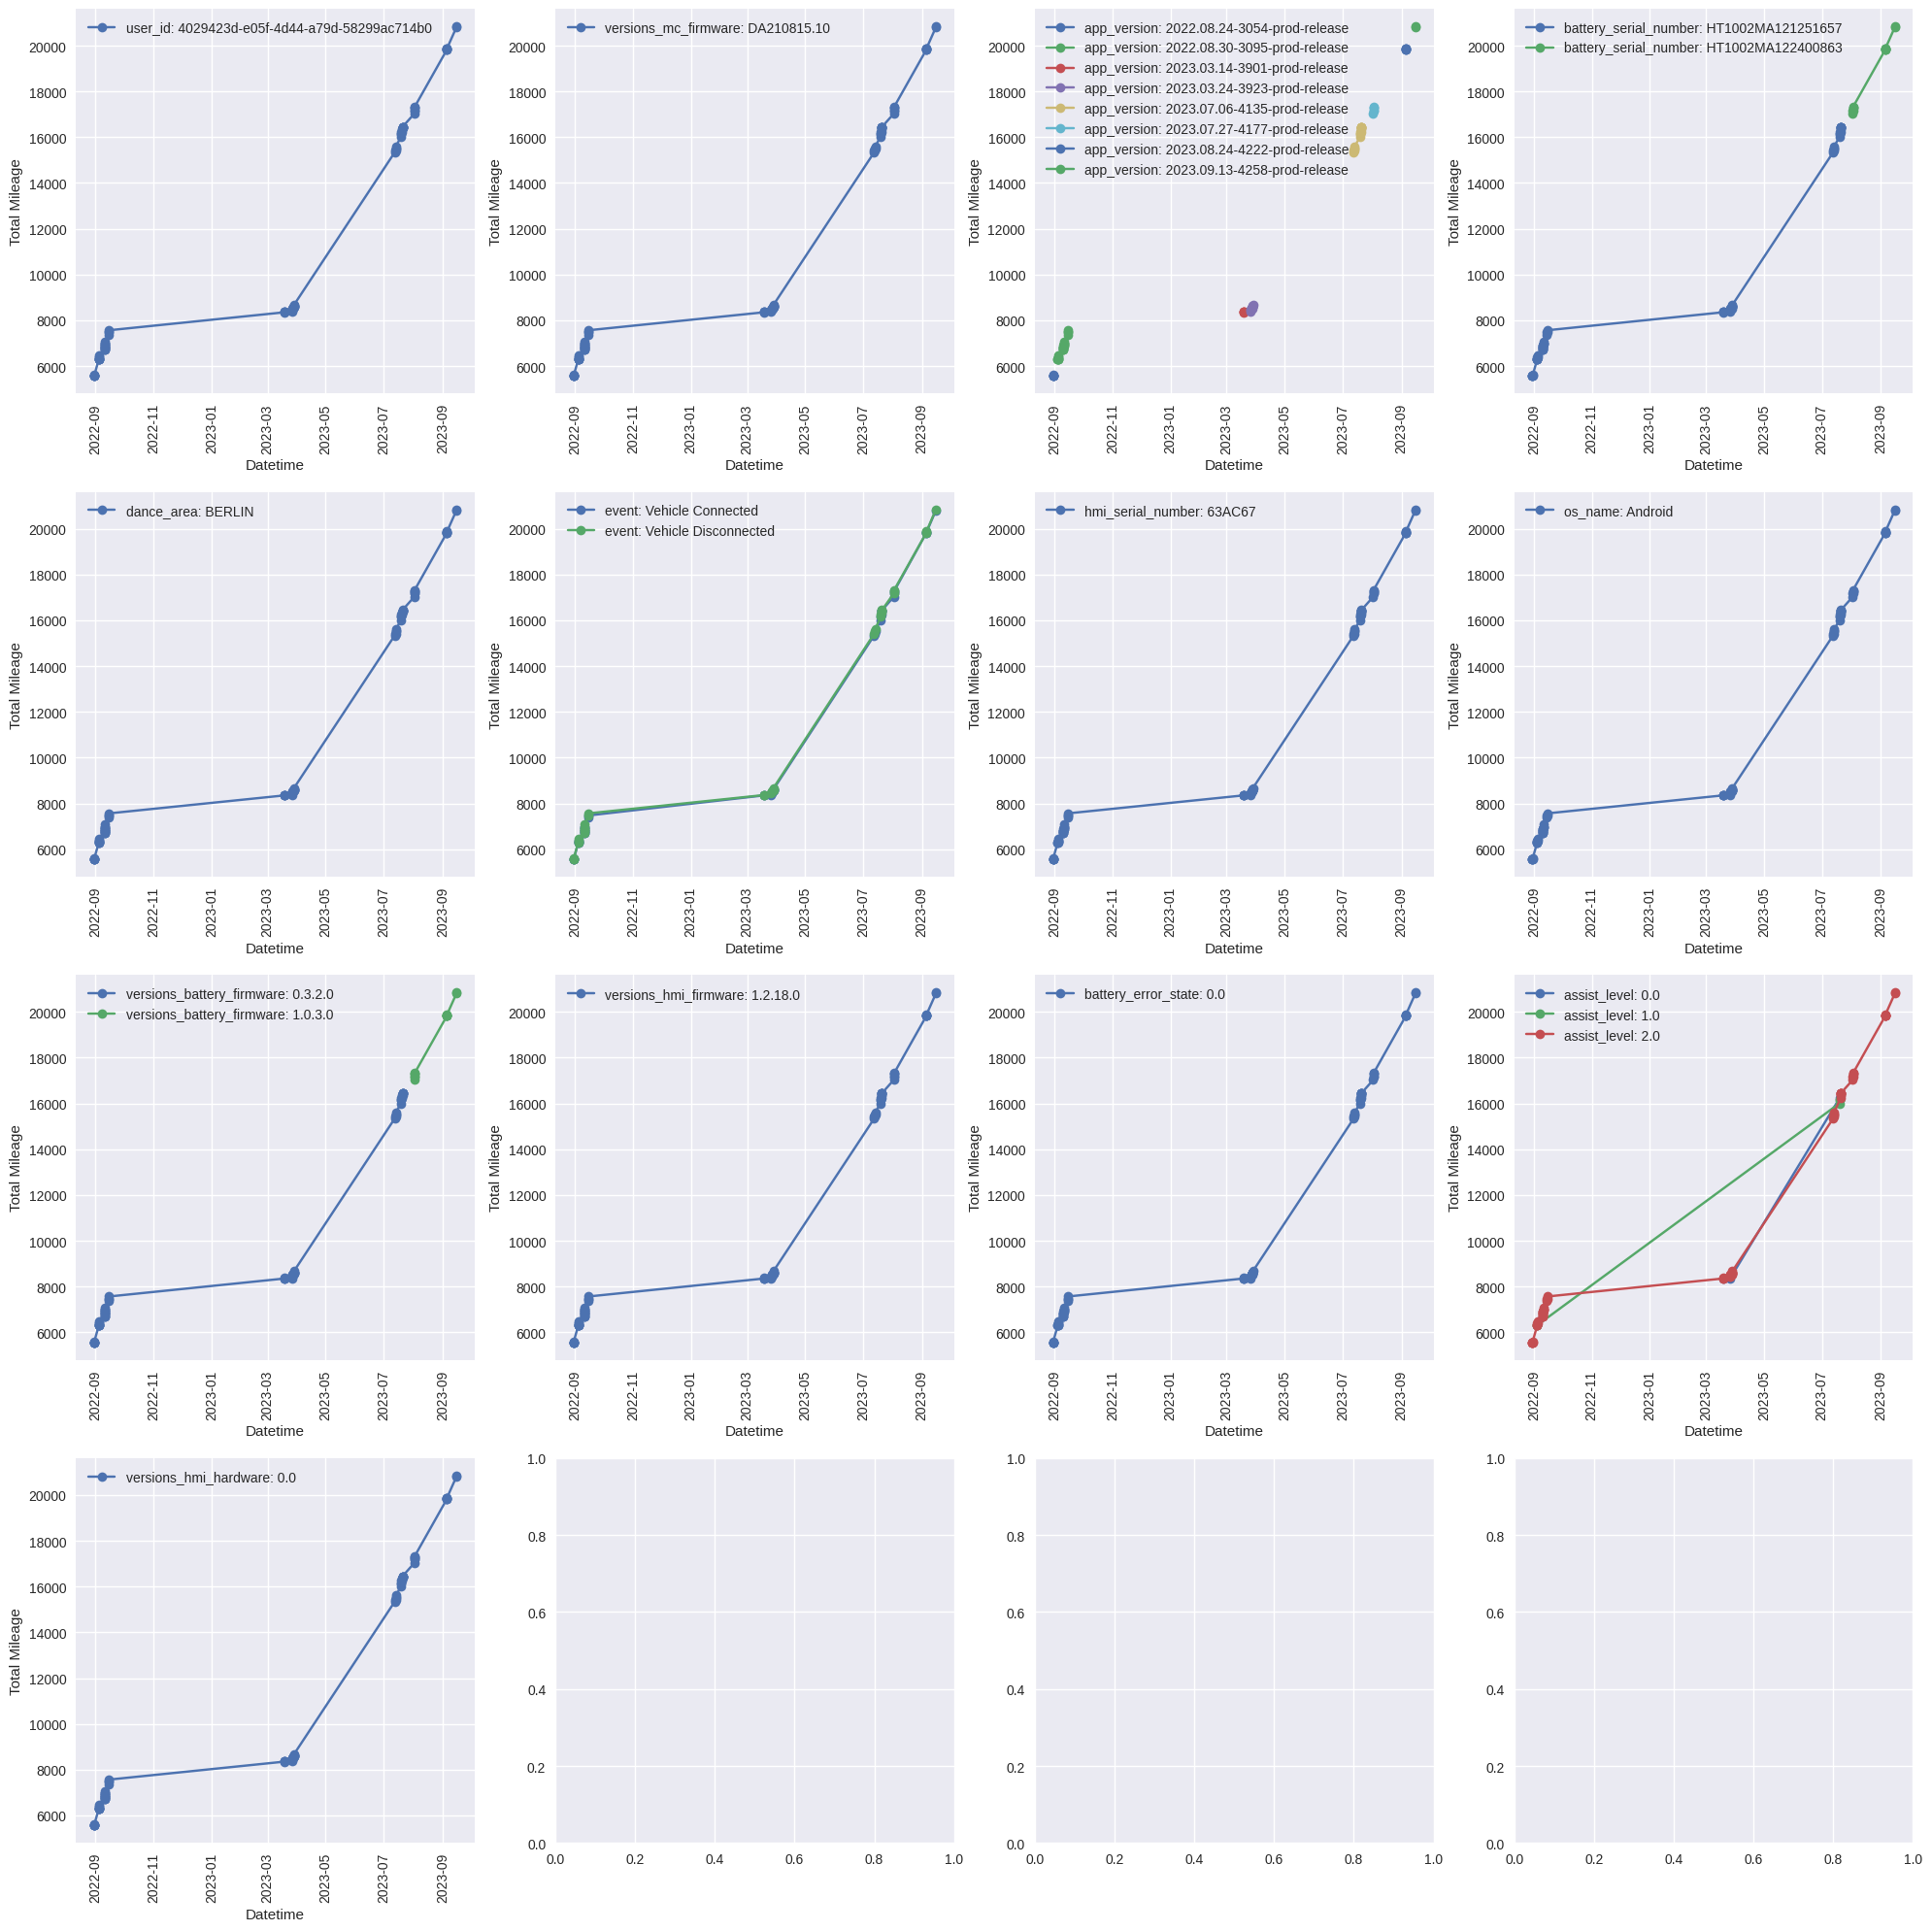

In [105]:
# Randomly select a vehicle ID
random_vehicle_id = random.choice(df['vehicle_id'].unique())

# Filter DataFrame for the selected vehicle ID
df_uv = df[df['vehicle_id'] == random_vehicle_id]

# Set up subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

# Iterate through each categorical column
for i, column in enumerate(categorical_columns):
    row, col = divmod(i, 4)  # Determine the row and column for the current subplot
    ax = axes[row, col]

    # Iterate through unique values in the current categorical column
    for value, group_df in df_uv.groupby(column):
        ax.plot(group_df['occurred_at_time'], group_df['total_mileage'], marker='o', linestyle='solid', label=f'{column}: {value}')

    #ax.set_title(f'Total Mileage Over Time - Vehicle ID: {random_vehicle_id}')
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Total Mileage')
    ax.legend()
    ax.tick_params(axis='x', rotation=90)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [8]:
# at least 50 observations per vehicle
df['ValueCount'] = df.groupby('vehicle_id')['occurred_at_time'].transform('count')
df1 = df[df['ValueCount']>50]
df1.head(2)

,vehicle_id,user_id,total_mileage,versions_mc_firmware,occurred_at_time,app_version,assist_level,battery_cells,battery_error_state,battery_serial_number,...,battery_state_remaining_capacity,dance_area,event,hmi_serial_number,os_name,remaining_mileage,versions_battery_firmware,versions_hmi_firmware,versions_hmi_hardware,ValueCount
1489509,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:05:03,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,NaN,PARIS,Vehicle Connected,453141343344,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204
2140144,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:08:29,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,NaN,PARIS,Vehicle Disconnected,453141343344,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204


In [9]:
(df1.shape, df1['vehicle_id'].nunique(), df1['battery_serial_number'].nunique())

((2650087, 30), 5435, 72908)

In [10]:
# at least 2 months of data per bike
result = df1.groupby('vehicle_id')['occurred_at_time'].agg(lambda x: (x.max() - x.min()).days).reset_index()
result.rename(columns={'occurred_at_time': 'DateDifference'}, inplace=True)

# Merge the result back into the original DataFrame
df2 = df1.merge(result, on='vehicle_id')
df2 = df2[df2['DateDifference']>60]
df2.head(2)

,vehicle_id,user_id,total_mileage,versions_mc_firmware,occurred_at_time,app_version,assist_level,battery_cells,battery_error_state,battery_serial_number,...,dance_area,event,hmi_serial_number,os_name,remaining_mileage,versions_battery_firmware,versions_hmi_firmware,versions_hmi_hardware,ValueCount,DateDifference
0,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:05:03,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,PARIS,Vehicle Connected,453141343344,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309
1,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:08:29,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,PARIS,Vehicle Disconnected,453141343344,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309


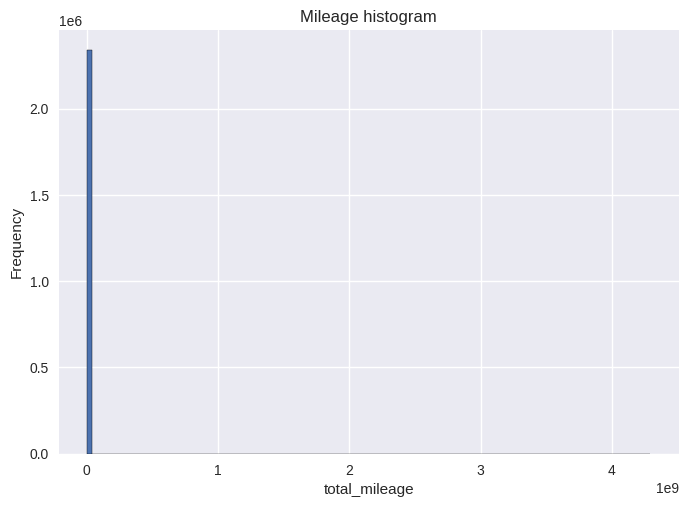

In [11]:
# Customize the histogram
n_bins = 100
plt.hist(df2['total_mileage'], bins=n_bins, edgecolor='k')



plt.title('Mileage histogram')
plt.xlabel('total_mileage')
plt.ylabel('Frequency')
plt.show()

In [12]:
# eliminate outliers drop
## looks like no bike log mileage > 21500
df3 = df2[df2['total_mileage']<23000]
df3

,vehicle_id,user_id,total_mileage,versions_mc_firmware,occurred_at_time,app_version,assist_level,battery_cells,battery_error_state,battery_serial_number,...,dance_area,event,hmi_serial_number,os_name,remaining_mileage,versions_battery_firmware,versions_hmi_firmware,versions_hmi_hardware,ValueCount,DateDifference
0,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:05:03,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,PARIS,Vehicle Connected,453141343344,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309
1,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:08:29,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,PARIS,Vehicle Disconnected,453141343344,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309
2,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:10:00,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,PARIS,Vehicle Disconnected,453141343344,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309
3,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,616.0,DA210815.10,2022-09-21 16:14:49,2022.9.13,1.0,NaN,0.0,4854313030324d41313231353230343339000000,...,PARIS,Vehicle Connected,453141343344,iOS,688.0,0.3.3.0,1.7.18.0,1.0,204,309
4,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,671.0,DA210815.10,2022-09-21 16:33:31,2022.9.13,1.0,NaN,0.0,4854313030324d41313231353230343339000000,...,PARIS,Vehicle Disconnected,453141343344,iOS,624.0,0.3.3.0,1.7.18.0,1.0,204,309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650082,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:39,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,HAMBURG,Vehicle Disconnected,22491330,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61
2650083,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:44,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,HAMBURG,Vehicle Connected,22491330,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61
2650084,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:58,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,HAMBURG,Vehicle Disconnected,22491330,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61
2650085,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:41:01,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,HAMBURG,Vehicle Connected,22491330,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61


In [13]:
(df3.shape, df3['vehicle_id'].nunique(), df3['battery_serial_number'].nunique())

((2338105, 31), 4124, 53736)

In [14]:
(df3['battery_serial_number'].nunique(), len(df3['battery_serial_number']), df3['battery_serial_number'].isna().sum())


(53736, 2338105, 283979)

In [15]:
## clean battery serial number -> valid numbers are 17 characters starting with 'HT' (e.g HT1002MA121220310)
# substring 17 characters
df4=df3.copy()
df4['battery_serial_number_clean'] = df4['battery_serial_number'].str[:17].astype(str)

# keep rows starting with 'HT' otherwise set to none
df4['battery_serial_number_clean'] = df4['battery_serial_number_clean'].apply(lambda x: x if ((x.startswith('HT')) & (len(x)==17)) else None)
df4

,vehicle_id,user_id,total_mileage,versions_mc_firmware,occurred_at_time,app_version,assist_level,battery_cells,battery_error_state,battery_serial_number,...,event,hmi_serial_number,os_name,remaining_mileage,versions_battery_firmware,versions_hmi_firmware,versions_hmi_hardware,ValueCount,DateDifference,battery_serial_number_clean
0,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:05:03,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,Vehicle Connected,453141343344,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309,None
1,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:08:29,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,Vehicle Disconnected,453141343344,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309,None
2,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:10:00,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,Vehicle Disconnected,453141343344,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309,None
3,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,616.0,DA210815.10,2022-09-21 16:14:49,2022.9.13,1.0,NaN,0.0,4854313030324d41313231353230343339000000,...,Vehicle Connected,453141343344,iOS,688.0,0.3.3.0,1.7.18.0,1.0,204,309,None
4,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,671.0,DA210815.10,2022-09-21 16:33:31,2022.9.13,1.0,NaN,0.0,4854313030324d41313231353230343339000000,...,Vehicle Disconnected,453141343344,iOS,624.0,0.3.3.0,1.7.18.0,1.0,204,309,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650082,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:39,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,Vehicle Disconnected,22491330,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289
2650083,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:44,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,Vehicle Connected,22491330,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289
2650084,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:58,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,Vehicle Disconnected,22491330,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289
2650085,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:41:01,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,Vehicle Connected,22491330,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289


In [16]:
df4['vehicle_id'].nunique()

4124

In [17]:
(df4['battery_serial_number_clean'].nunique(), len(df4['battery_serial_number_clean']), df4['battery_serial_number_clean'].isna().sum())

(5617, 2338105, 844941)

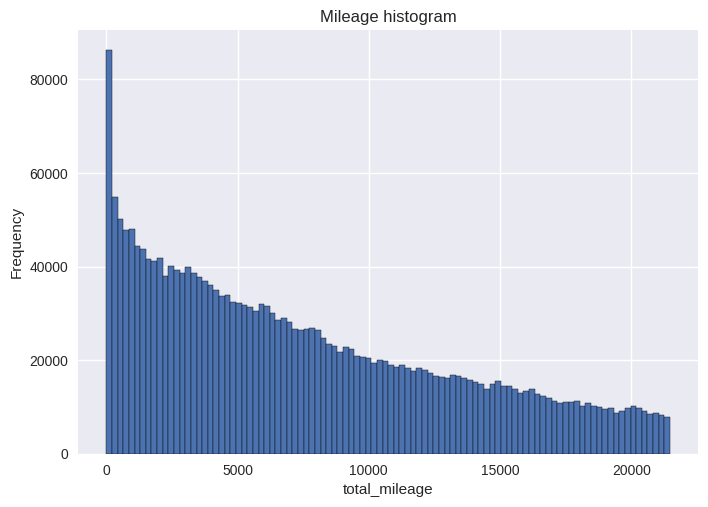

In [18]:
# Customize the histogram
n_bins = 100
plt.hist(df4['total_mileage'], bins=n_bins, edgecolor='k')



plt.title('Mileage histogram')
plt.xlabel('total_mileage')
plt.ylabel('Frequency')
plt.show()

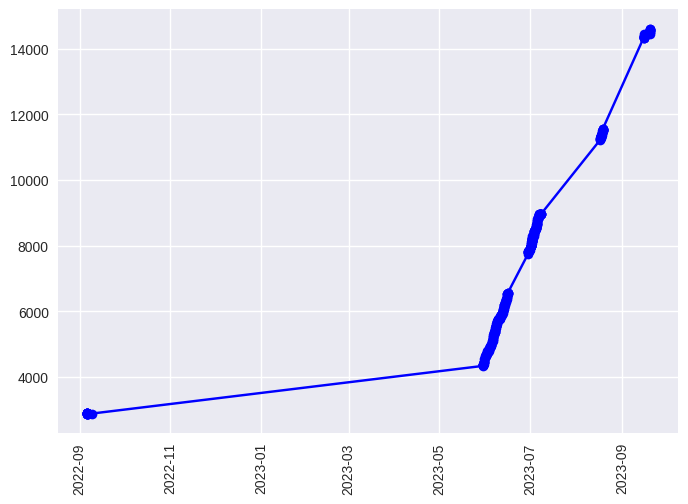

In [19]:
df_uv=df4[df4['vehicle_id'] == random.choice(df4['vehicle_id'].unique())]
plt.plot(df_uv['occurred_at_time'], df_uv['total_mileage'], marker='o', linestyle='solid', color='b')
plt.xticks(rotation=90)
plt.show()

#df_uv

In [20]:
# average number of battery per bike
battery_counts = df4.groupby('vehicle_id')['battery_serial_number_clean'].nunique().reset_index()
battery_counts.describe()

,battery_serial_number_clean
count,4124.000000
mean,1.851358
std,1.380355
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,23.000000


In [21]:
battery_counts.head()

,vehicle_id,battery_serial_number_clean
0,0000a2c8-03b6-4b57-a74b-851cb77c598d,1
1,00214cc8-4fc8-4dab-b5a8-4b9063f145ec,3
2,003c3bdc-53fd-4889-acdf-f2840cf9218b,1
3,005022ad-645d-4865-8a12-c279e0a41dd7,0
4,0060548b-8471-445a-ae1d-69a626ae0b83,3


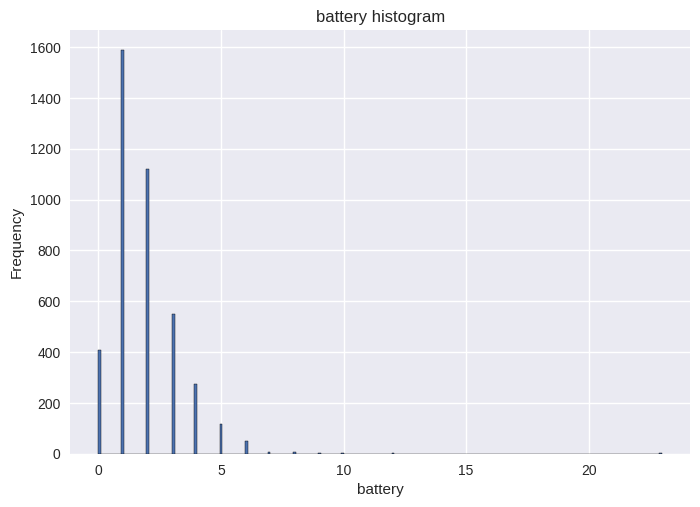

In [22]:
n_bins = 200
plt.hist(battery_counts['battery_serial_number_clean'], bins=n_bins, edgecolor='k')

plt.title('battery histogram')
plt.xlabel('battery')
plt.ylabel('Frequency')
plt.show()

In [23]:
percentile_80 = battery_counts['battery_serial_number_clean'].quantile(0.80)
percentile_80

3.0

In [24]:
# Vehicles reached 20000 total mileage
max_mileage_per_vehicle = df4.groupby('vehicle_id')['total_mileage'].max().reset_index()

bikes_above_20000_per_vehicle = max_mileage_per_vehicle[max_mileage_per_vehicle['total_mileage'] >= 20000]['vehicle_id'].unique()


# for bikes above 20,000 how many drops
filtered_rows = df4.copy()
filtered_rows = filtered_rows[filtered_rows['vehicle_id'].isin(bikes_above_20000_per_vehicle)]

filtered_rows['mileage_diff'] = filtered_rows.groupby('vehicle_id')['total_mileage'].diff()

count_drops_below_20000 = filtered_rows[filtered_rows['mileage_diff'] < 0]['vehicle_id'].unique()



In [25]:

# Elements in list1 but not in list2
count_dont_drops_below_20000 = list(set(bikes_above_20000_per_vehicle) - set(count_drops_below_20000))

In [26]:
len(count_drops_below_20000)

697

In [27]:
count_dont_drops_below_20000

['b0ac9bd4-227c-4f27-8e4e-194cefb4ee43',
 '3445b1ae-61a3-4c35-b2ca-195ccf4de7fa',
 '8b6b6954-fa2e-41b4-9da0-411ab4509b0b',
 '5fc54e64-004e-480f-8bc7-38e81bb6446f',
 '547b6222-5cc4-4e51-95f8-96f1bcba8185']

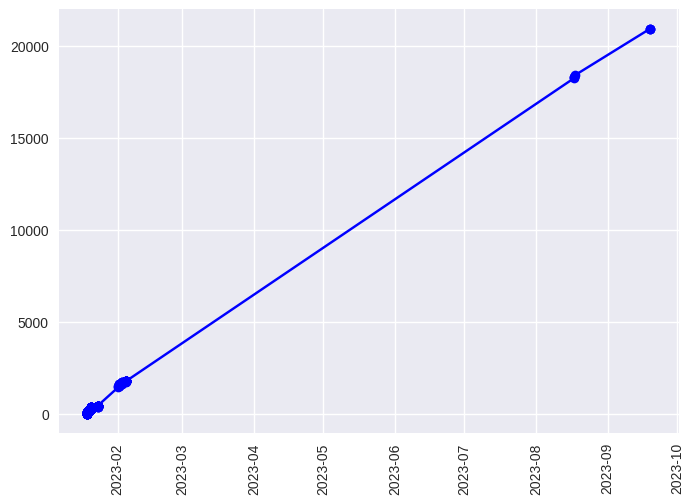

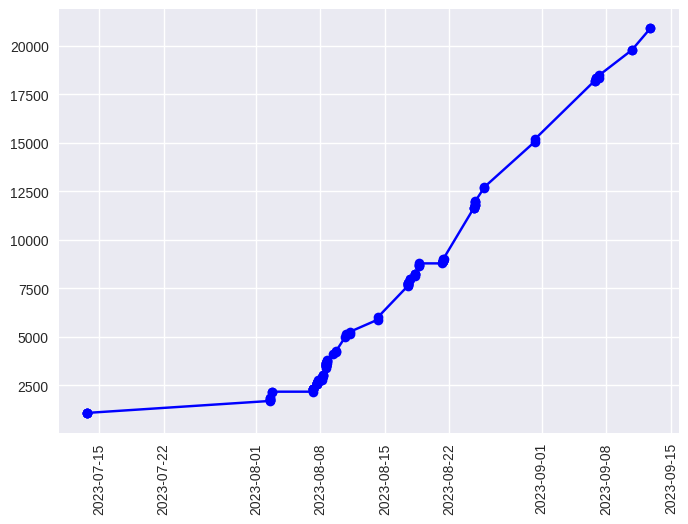

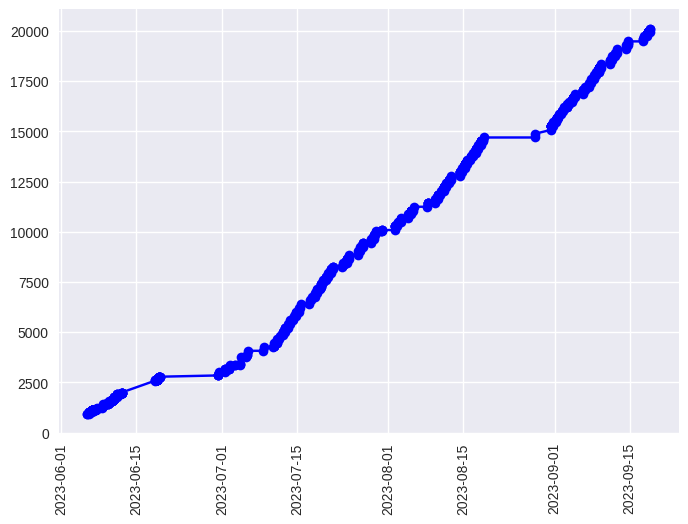

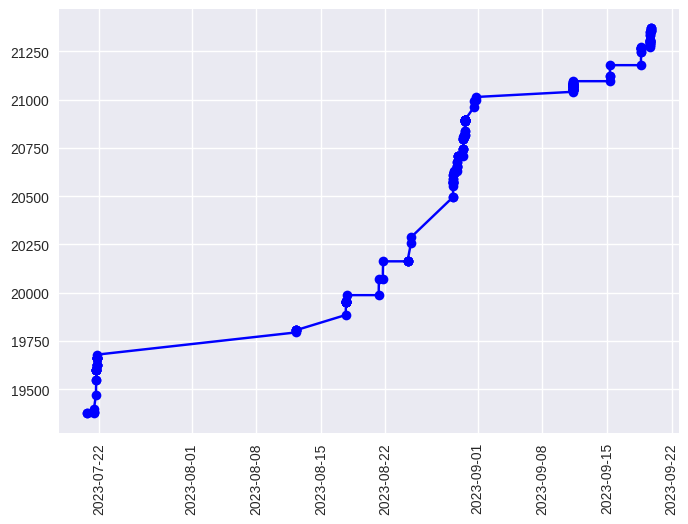

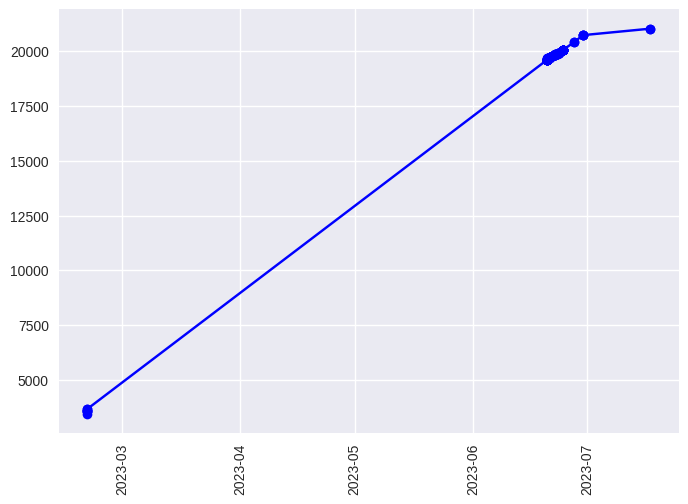

In [28]:
for v in count_dont_drops_below_20000:
  df_uv=df4[df4['vehicle_id'] == v]
  plt.plot(df_uv['occurred_at_time'], df_uv['total_mileage'], marker='o', linestyle='solid', color='b')
  plt.xticks(rotation=90)
  plt.show()

#df_uv

In [29]:
# accumulating the reseted total mileage after 20000
df5 = df4.copy()
df5['clean_total_mileage']=df5['total_mileage']
#df5['mileage_diff'] = df5.groupby('vehicle_id')['clean_total_mileage'].diff()
df5['cumulative_max'] = df5.groupby('vehicle_id')['clean_total_mileage'].cummax()
df5['clean_total_mileage'] = df5.apply(lambda row: row['clean_total_mileage'] +
                                       row['cumulative_max'] if (row['clean_total_mileage']<15000 and
                                                                 row['cumulative_max']>20000 and
                                                                  (row['clean_total_mileage']-row['cumulative_max'] <0))
                                       else row['clean_total_mileage'], axis=1)
# df5

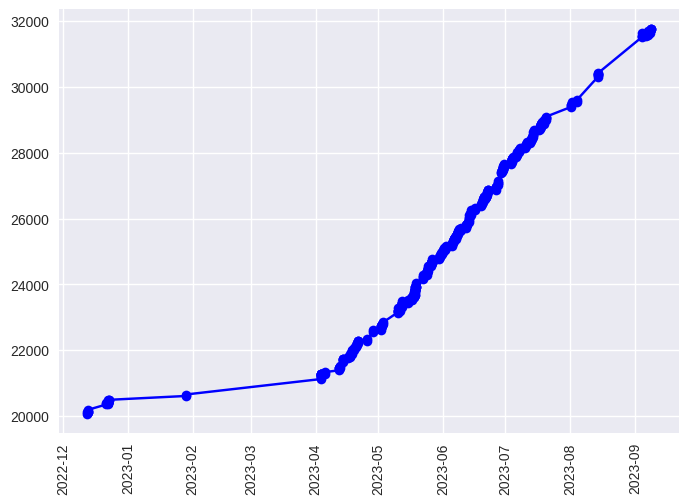

In [30]:
# for v in count_drops_below_20000:
#   df_uv=df5[df5['vehicle_id'] == v]
#   plt.plot(df_uv['occurred_at_time'], df_uv['clean_total_mileage'], marker='o', linestyle='solid', color='b')
#   plt.xticks(rotation=90)
#   plt.show()

# #df_uv

df_uv=df5[df5['vehicle_id'] == random.choice(count_drops_below_20000)]
plt.plot(df_uv['occurred_at_time'], df_uv['clean_total_mileage'], marker='o', linestyle='solid', color='b')
plt.xticks(rotation=90)
plt.show()

In [31]:
# # eliminate outliers drop
# df6 = df5[df5['clean_total_mileage']<35000]
# df6

In [32]:
# for v in count_drops_below_20000:
#   df_uv=df6[df6['vehicle_id'] == v]
#   plt.plot(df_uv['occurred_at_time'], df_uv['clean_total_mileage'], marker='o', linestyle='solid', color='b')
#   plt.xticks(rotation=90)
#   plt.show()

# #df_uv

In [33]:
# removing rows where 'total_mileage' is less than the previous one for a unique 'vehicle_id'
df6 = df5.copy()

df6['cumulative_max'] = df6.groupby('vehicle_id')['clean_total_mileage'].cummax()
df6 = df6[df6['clean_total_mileage'] >= df6['cumulative_max']]

#df6.drop(columns=['cumulative_max'], inplace=True)

print("Filtered DataFrame:")
df6

Filtered DataFrame:


,vehicle_id,user_id,total_mileage,versions_mc_firmware,occurred_at_time,app_version,assist_level,battery_cells,battery_error_state,battery_serial_number,...,os_name,remaining_mileage,versions_battery_firmware,versions_hmi_firmware,versions_hmi_hardware,ValueCount,DateDifference,battery_serial_number_clean,clean_total_mileage,cumulative_max
0,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:05:03,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309,None,0.0,0.0
1,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:08:29,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309,None,0.0,0.0
2,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,0.0,DA210815.10,2022-09-13 18:10:00,2022.8.29,2.0,NaN,0.0,4854313030324d41313231353230343339000000,...,iOS,588.0,0.3.3.0,1.7.18.0,1.0,204,309,None,0.0,0.0
3,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,616.0,DA210815.10,2022-09-21 16:14:49,2022.9.13,1.0,NaN,0.0,4854313030324d41313231353230343339000000,...,iOS,688.0,0.3.3.0,1.7.18.0,1.0,204,309,None,616.0,616.0
4,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,671.0,DA210815.10,2022-09-21 16:33:31,2022.9.13,1.0,NaN,0.0,4854313030324d41313231353230343339000000,...,iOS,624.0,0.3.3.0,1.7.18.0,1.0,204,309,None,671.0,671.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650082,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:39,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289,3746.0,3746.0
2650083,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:44,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289,3746.0,3746.0
2650084,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:58,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289,3746.0,3746.0
2650085,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:41:01,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289,3746.0,3746.0


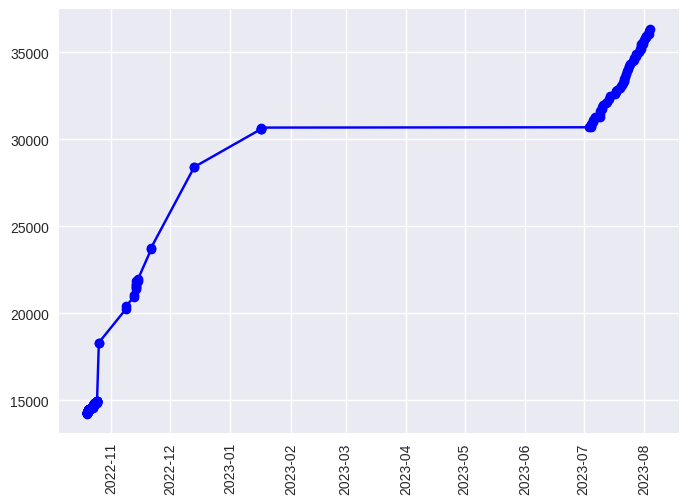

In [34]:
df_uv=df6[df6['vehicle_id'] == random.choice(count_drops_below_20000)]
plt.plot(df_uv['occurred_at_time'], df_uv['clean_total_mileage'], marker='o', linestyle='solid', color='b')
plt.xticks(rotation=90)
plt.show()

In [35]:
# data with no battery serial number, soc and soh records
df7=df6[(~df6['battery_serial_number_clean'].isna() & ~df6['battery_state_battery_soc'].isna() & ~df6['battery_state_battery_soh'].isna())]

In [36]:
df7

,vehicle_id,user_id,total_mileage,versions_mc_firmware,occurred_at_time,app_version,assist_level,battery_cells,battery_error_state,battery_serial_number,...,os_name,remaining_mileage,versions_battery_firmware,versions_hmi_firmware,versions_hmi_hardware,ValueCount,DateDifference,battery_serial_number_clean,clean_total_mileage,cumulative_max
45,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,15780.0,DA210815.10,2023-03-17 12:45:46,2023.2.15,1.0,NaN,0.0,HT1002MA121520439,...,iOS,320.0,0.3.3.0,1.7.18.0,1.0,204,309,HT1002MA121520439,15780.0,15780.0
46,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,15834.0,DA210815.10,2023-03-17 13:07:24,2023.2.15,1.0,NaN,0.0,HT1002MA121520439,...,iOS,240.0,0.3.3.0,1.7.18.0,1.0,204,309,HT1002MA121520439,15834.0,15834.0
48,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,15894.0,DA210815.10,2023-03-17 14:36:29,2023.2.15,1.0,NaN,0.0,HT1002MA121520439,...,iOS,144.0,0.3.3.0,1.7.18.0,1.0,204,309,HT1002MA121520439,15894.0,15894.0
49,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,15894.0,DA210815.10,2023-03-20 10:12:01,2023.3.13,1.0,NaN,0.0,HT1002MA121520439,...,iOS,792.0,0.3.3.0,1.7.18.0,1.0,204,309,HT1002MA121520439,15894.0,15894.0
50,0000a2c8-03b6-4b57-a74b-851cb77c598d,0836db5b-98ca-4d95-908e-d93304c6ae68,15935.0,DA210815.10,2023-03-20 10:30:07,2023.3.13,1.0,NaN,0.0,HT1002MA121520439,...,iOS,736.0,0.3.3.0,1.7.18.0,1.0,204,309,HT1002MA121520439,15935.0,15935.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650082,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:39,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289,3746.0,3746.0
2650083,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:44,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289,3746.0,3746.0
2650084,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:40:58,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289,3746.0,3746.0
2650085,ffe4c2ad-5fbb-49a2-a26f-71d1521de21d,1a0f22af-9e76-4e96-a03f-bb8912da3a9c,3746.0,DA210815.10,2023-08-08 18:41:01,2023.8.4,2.0,NaN,0.0,HT1002MA122441289HT1002MA122441289HT1002MA1224...,...,iOS,456.0,1.0.6.0,65.1.39.34,2.0,586,61,HT1002MA122441289,3746.0,3746.0


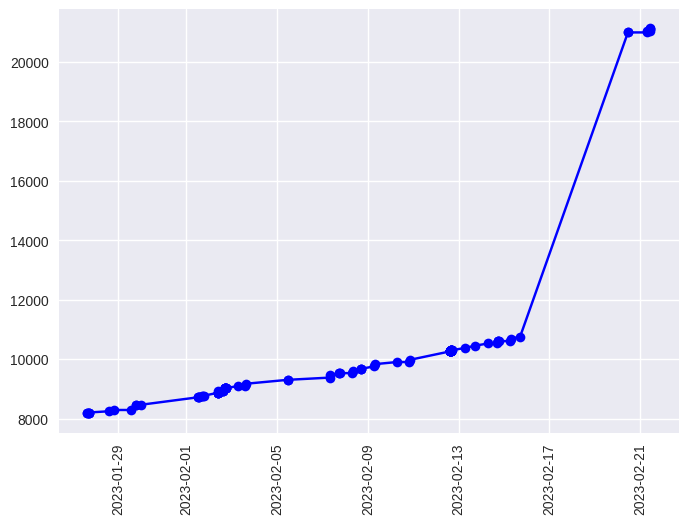

In [37]:
df_uv=df7[df7['vehicle_id'] == random.choice(count_drops_below_20000)]
plt.plot(df_uv['occurred_at_time'], df_uv['clean_total_mileage'], marker='o', linestyle='solid', color='b')
plt.xticks(rotation=90)
plt.show()

In [38]:
# # remove ebikes that don't have valid battery_serial_number and fill missing values
# vehicles = df3[df3.groupby('vehicle_id')['battery_serial_number_clean'].transform(lambda x: x.isnull().all())]['vehicle_id'].unique()
# df3 = df3[~df3['vehicle_id'].isin(vehicles)]

# # Fill Missing values for battery_serial_number_clean by propagating last valid observation
# df3['battery_serial_number_clean'] = df3.groupby('vehicle_id')['battery_serial_number_clean'].fillna(method='ffill')
# # Fill Missing values for battery_serial_number_clean by propagating next valid observation
# df3['battery_serial_number_clean'] = df3.groupby('vehicle_id')['battery_serial_number_clean'].fillna(method='bfill')

In [39]:
df7['vehicle_id'].nunique()

3657

# Analysis

## size check

In [40]:
# df6: data without noise in the total mileage
# df7: data without noise in the total mileage and with no missing values for battery

In [41]:

[len(df6),len(df7)]

[1778520, 1075300]

In [42]:
df7['battery_serial_number_clean'].nunique()
# df7['vehicle_id'].nunique()

5158

### trial

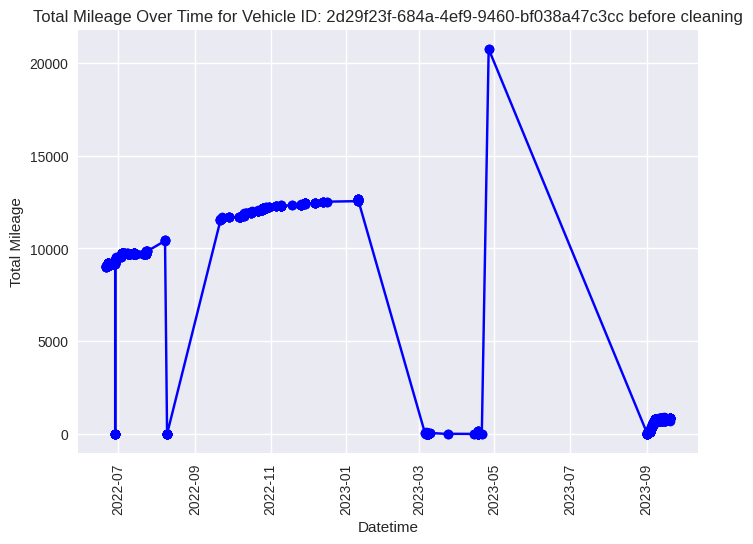

In [43]:
vehicle_id='2d29f23f-684a-4ef9-9460-bf038a47c3cc'
df_uv1=df4[df4['vehicle_id'] ==vehicle_id]
plt.plot(df_uv1['occurred_at_time'], df_uv1['total_mileage'], marker='o', linestyle='solid', color='b')
plt.xticks(rotation=90)
plt.title(f'Total Mileage Over Time for Vehicle ID: {vehicle_id} before cleaning')
plt.xlabel('Datetime')
plt.ylabel('Total Mileage')
plt.legend()
plt.show()

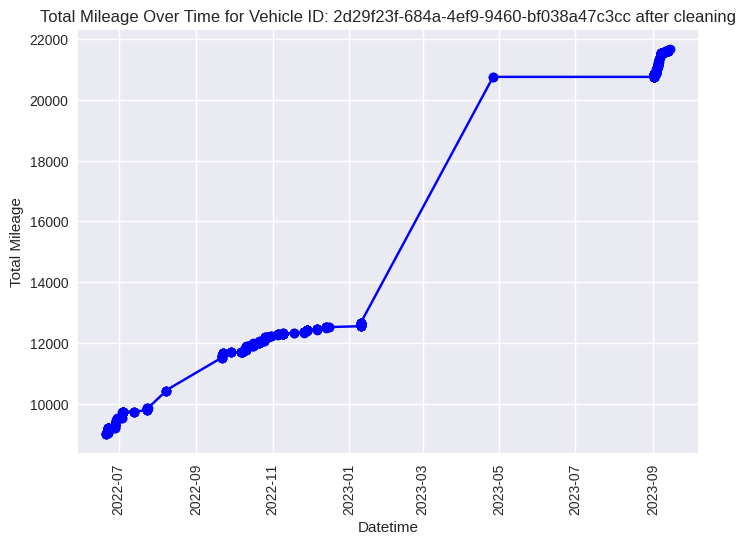

In [44]:
df_uv2=df6[df6['vehicle_id'] == vehicle_id]
plt.plot(df_uv2['occurred_at_time'], df_uv2['clean_total_mileage'], marker='o', linestyle='solid', color='b')
plt.xticks(rotation=90)
plt.title(f'Total Mileage Over Time for Vehicle ID: {vehicle_id} after cleaning')
plt.xlabel('Datetime')
plt.ylabel('Total Mileage')
#plt.legend()
plt.show()

<ipython-input-45-02e8682497a7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df_uv1['occurred_at_time'], rotation=90)
<ipython-input-45-02e8682497a7>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_uv2['occurred_at_time'], rotation=90)


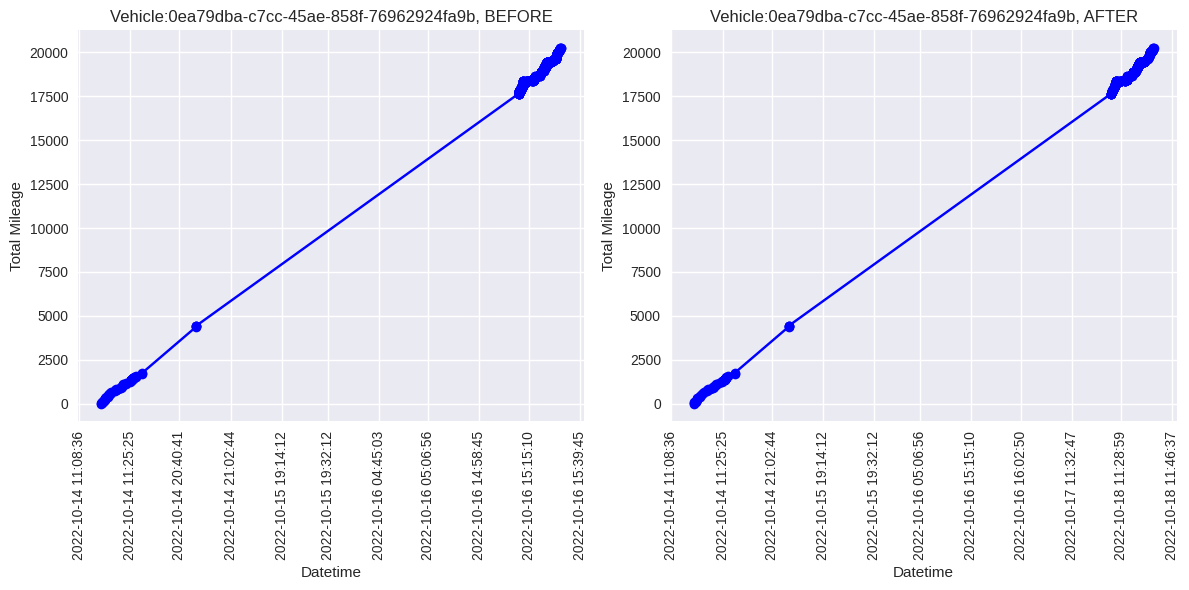

In [45]:
#vehicle_id='2d29f23f-684a-4ef9-9460-bf038a47c3cc'
vehicle_id=random.choice(df6['vehicle_id'].unique())
# Set the figure size and create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for the first subplot
df_uv1 = df4[df4['vehicle_id'] == vehicle_id]
axes[0].plot(df_uv1['occurred_at_time'], df_uv1['total_mileage'], marker='o', linestyle='solid', color='b')
axes[0].set_xticklabels(df_uv1['occurred_at_time'], rotation=90)
axes[0].set_title(f'Vehicle:{vehicle_id}, BEFORE')
axes[0].set_xlabel('Datetime')
axes[0].set_ylabel('Total Mileage')
#axes[0].legend()

# Plot for the second subplot
df_uv2 = df6[df6['vehicle_id'] == vehicle_id]
axes[1].plot(df_uv2['occurred_at_time'], df_uv2['clean_total_mileage'], marker='o', linestyle='solid', color='b')
axes[1].set_xticklabels(df_uv2['occurred_at_time'], rotation=90)
axes[1].set_title(f'Vehicle:{vehicle_id}, AFTER')
axes[1].set_xlabel('Datetime')
axes[1].set_ylabel('Total Mileage')
#axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## visualization before cleaning and after cleaning

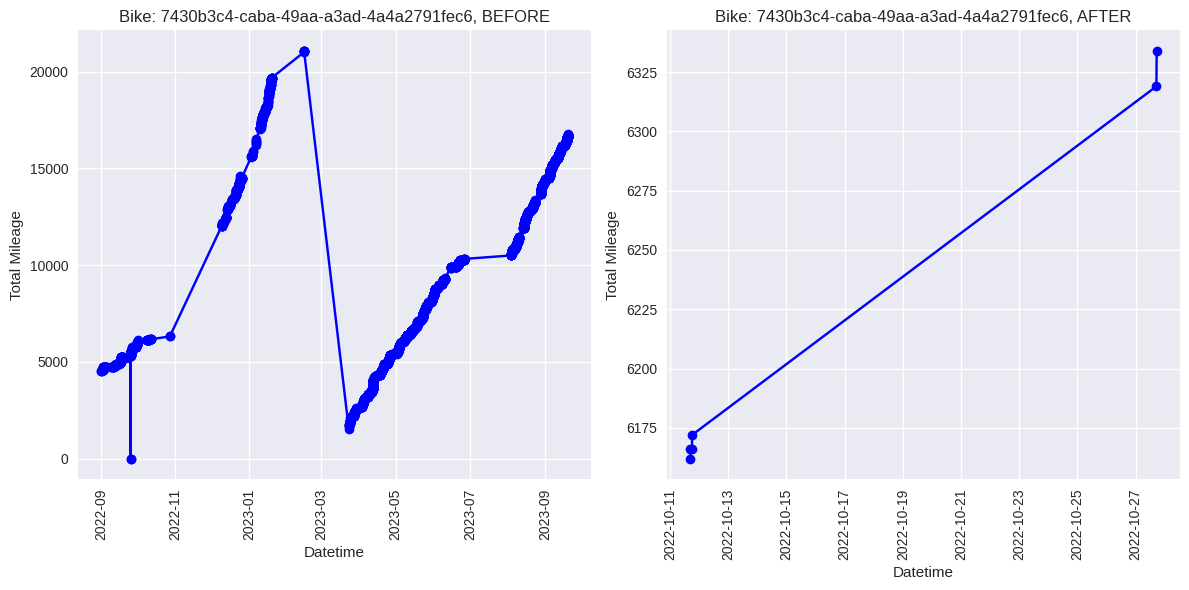

In [46]:


#vehicle_id='2d29f23f-684a-4ef9-9460-bf038a47c3cc'
vehicle_id=random.choice(df7['vehicle_id'].unique())

# Set the figure size and create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for the first subplot
df_uv1 = df4[df4['vehicle_id'] == vehicle_id]
axes[0].plot(df_uv1['occurred_at_time'], df_uv1['total_mileage'], marker='o', linestyle='solid', color='b')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title(f'Bike: {vehicle_id}, BEFORE')
axes[0].set_xlabel('Datetime')
axes[0].set_ylabel('Total Mileage')

# Plot for the second subplot
df_uv2 = df7[df7['vehicle_id'] == vehicle_id]
axes[1].plot(df_uv2['occurred_at_time'], df_uv2['clean_total_mileage'], marker='o', linestyle='solid', color='b')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_title(f'Bike: {vehicle_id}, AFTER')
axes[1].set_xlabel('Datetime')
axes[1].set_ylabel('Total Mileage')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


## Descriptive analysis and visualization

### battery usage per bike

In [47]:
## number of bateries per each vehicle
df8=df7.copy()
battery_counts = df8.groupby('vehicle_id')['battery_serial_number_clean'].nunique().reset_index()
battery_counts.describe()

,battery_serial_number_clean
count,3657.000000
mean,1.821438
std,1.045779
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,18.000000


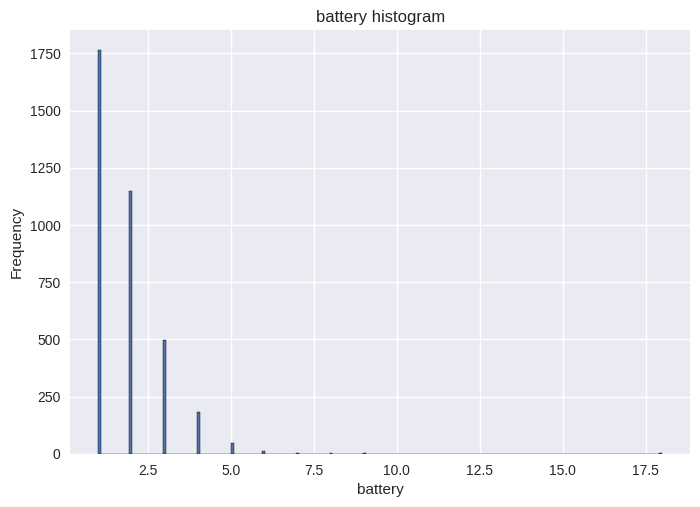

In [48]:
n_bins = 200
plt.hist(battery_counts['battery_serial_number_clean'], bins=n_bins, edgecolor='k')

plt.title('battery histogram')
plt.xlabel('battery')
plt.ylabel('Frequency')
plt.show()

### number of vehicle per month with split per city

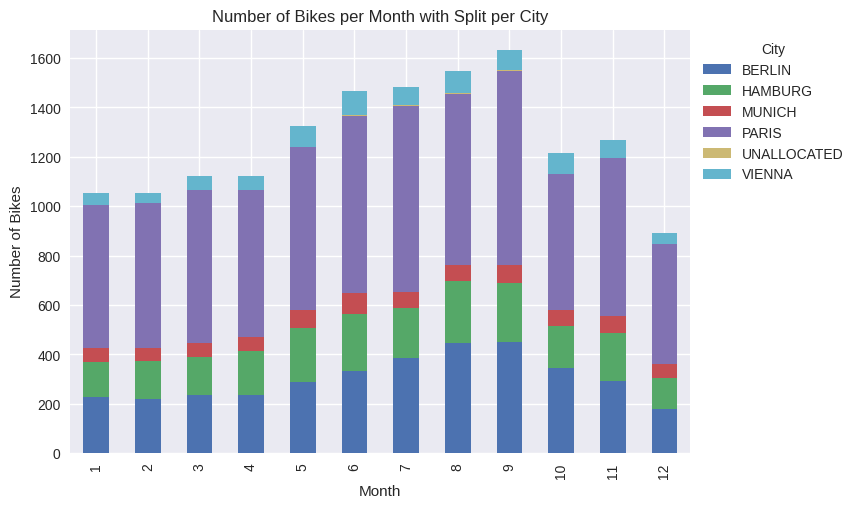

In [49]:
# Extract month from the date
df8['month'] = df8['occurred_at_time'].dt.month

# Group by month and city, then count the number of unique vehicles
vehicle_counts = df8.groupby(['month', 'dance_area'])['vehicle_id'].nunique().reset_index()

# Pivot the table for better visualization
pivot_table = vehicle_counts.pivot_table(index='month', columns='dance_area', values='vehicle_id', fill_value=0)

# Plotting
pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Month')
plt.ylabel('Number of Bikes')
plt.title('Number of Bikes per Month with Split per City')
plt.legend(title='City', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In [50]:
pivot_table

dance_area,BERLIN,HAMBURG,MUNICH,PARIS,UNALLOCATED,VIENNA
month,,,,,,
1,227,143,56,577,0,49
2,221,151,54,587,0,40
3,236,155,55,618,0,60
4,235,177,59,593,1,59
5,287,220,72,660,2,83
6,333,231,83,719,3,97
7,385,203,63,754,3,73
8,447,250,64,695,3,89
9,450,238,75,785,2,83


### number of users per month with split per city

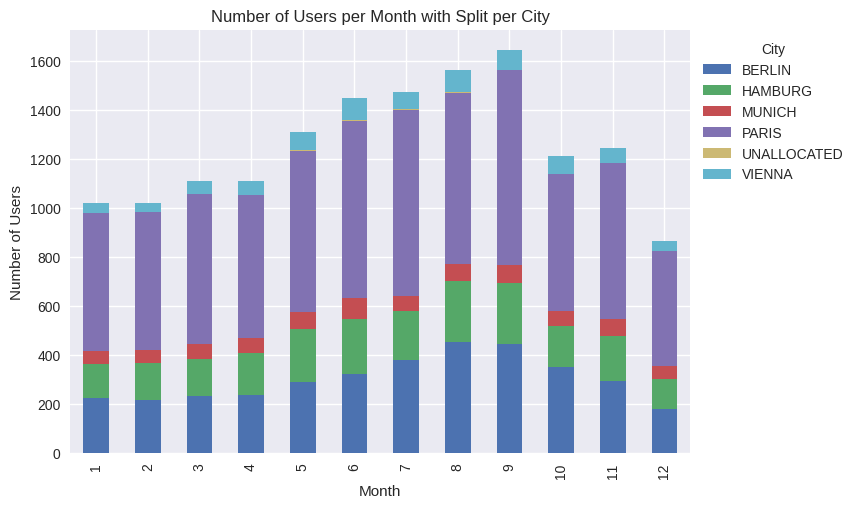

In [51]:
# Extract month from the date
#df8=df7.copy()
df8['month'] = df8['occurred_at_time'].dt.month

# Group by month and city, then count the number of unique vehicles
vehicle_counts = df8.groupby(['month', 'dance_area'])['user_id'].nunique().reset_index()

# Pivot the table for better visualization
pivot_table = vehicle_counts.pivot_table(index='month', columns='dance_area', values='user_id', fill_value=0)

# Plotting
pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.title('Number of Users per Month with Split per City')
plt.legend(title='City', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In [52]:
pivot_table

dance_area,BERLIN,HAMBURG,MUNICH,PARIS,UNALLOCATED,VIENNA
month,,,,,,
1,226,137,54,562,0,40
2,218,149,52,564,0,36
3,234,151,59,611,0,55
4,236,173,59,585,1,56
5,291,216,69,656,2,76
6,324,223,85,723,3,88
7,379,201,62,757,3,72
8,455,249,67,697,3,90
9,447,245,74,796,2,80


### average battery SOH across bikes per month, also per city

per month

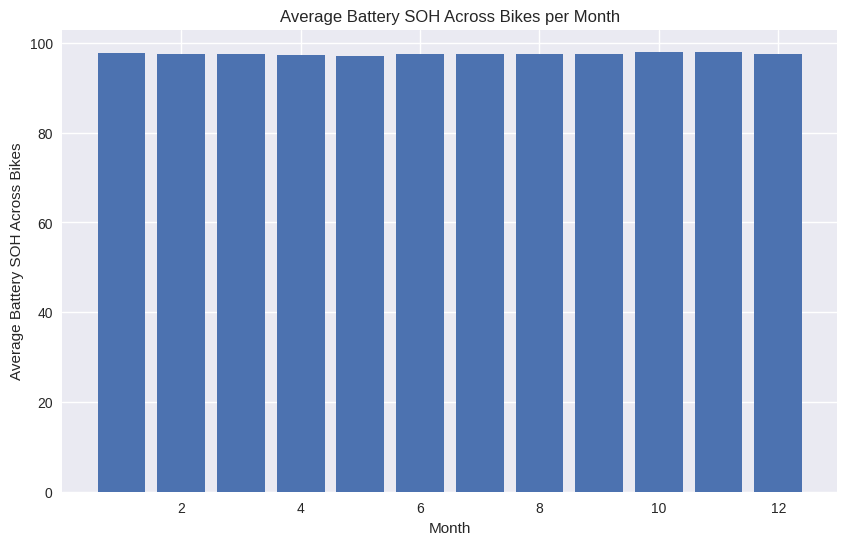

In [53]:


# Group by month and calculate the average battery SOH
avg_soh_per_month = df8.groupby(['month', 'vehicle_id'])['battery_state_battery_soh'].mean().reset_index()

# Group by month and calculate the average battery SOH across all bikes
avg_soh_across_bikes = avg_soh_per_month.groupby('month')['battery_state_battery_soh'].mean().reset_index()

# Create a bar plot for average battery SOH across bikes per month
plt.figure(figsize=(10, 6))
plt.bar(avg_soh_across_bikes['month'], avg_soh_across_bikes['battery_state_battery_soh'])
plt.xlabel('Month')
plt.ylabel('Average Battery SOH Across Bikes')
plt.title('Average Battery SOH Across Bikes per Month')
plt.show()


In [54]:
avg_soh_across_bikes

,month,battery_state_battery_soh
0,1,97.659391
1,2,97.554730
2,3,97.439405
3,4,97.377458
4,5,97.192191
5,6,97.443427
6,7,97.610594
7,8,97.639339
8,9,97.499706
9,10,98.038996


per city

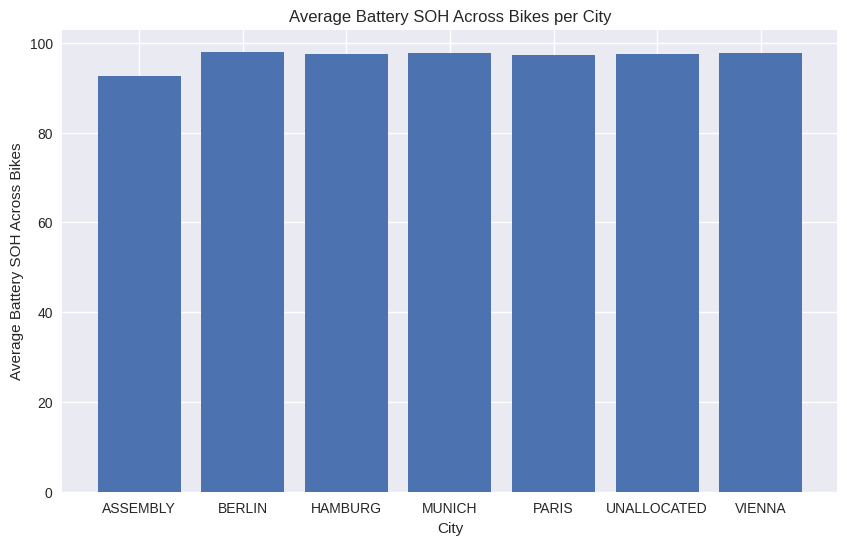

In [55]:


# Group by month and calculate the average battery SOH
avg_soh_per_city = df.groupby(['dance_area', 'vehicle_id'])['battery_state_battery_soh'].mean().reset_index()

# Group by month and calculate the average battery SOH across all bikes
avg_soh_across_bikes2 = avg_soh_per_city.groupby('dance_area')['battery_state_battery_soh'].mean().reset_index()

# Create a bar plot for average battery SOH across bikes per City
plt.figure(figsize=(10, 6))
plt.bar(avg_soh_across_bikes2['dance_area'], avg_soh_across_bikes2['battery_state_battery_soh'])
plt.xlabel('City')
plt.ylabel('Average Battery SOH Across Bikes')
plt.title('Average Battery SOH Across Bikes per City')
plt.show()


In [56]:
avg_soh_across_bikes2

,dance_area,battery_state_battery_soh
0,ASSEMBLY,92.500000
1,BERLIN,98.008794
2,HAMBURG,97.564440
3,MUNICH,97.750026
4,PARIS,97.330641
5,UNALLOCATED,97.400971
6,VIENNA,97.679452


### users and vehicles split by season

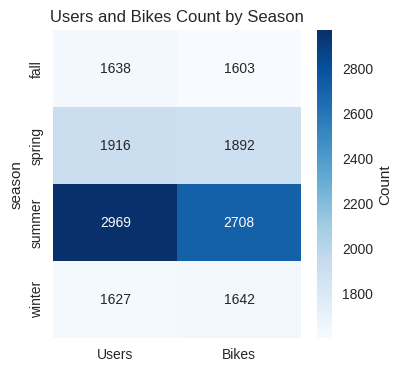

In [57]:
# Extract season from the date
df8['season'] = df8['occurred_at_time'].dt.month.apply(lambda x:
                                                        'winter' if x in [12, 1, 2] else
                                                        'spring' if x in [3, 4, 5] else
                                                        'summer' if x in [6, 7, 8, 9] else
                                                        'fall' if x in [10, 11] else
                                                        'other'
                                                       )

# Count users and vehicles for each season
season_counts = df8.groupby(['season'])[['user_id', 'vehicle_id']].nunique()

# Rename columns for better readability
season_counts = season_counts.rename(columns={'user_id': 'Users', 'vehicle_id': 'Bikes'})

# Plot the matrix
plt.figure(figsize=(4, 4))
sns.heatmap(season_counts, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Users and Bikes Count by Season')
plt.show()


### min, max and mean time (months) a user can subscribe (considering users who used one bike)

In [58]:
# Count the number of unique bikes used by each user
user_bike_counts = df8.groupby('user_id')['vehicle_id'].nunique()

# Filter users who used only one bike
single_bike_users = user_bike_counts[user_bike_counts == 1].index

# Filter the DataFrame to include only users who used one bike
df_single_bike_users = df8[df8['user_id'].isin(single_bike_users)]

# Calculate the duration (in months) for each user
user_subscription_duration = df_single_bike_users.groupby('user_id')['occurred_at_time'].agg(lambda x: (x.max() - x.min()).days / 30).reset_index()
# user_subscription_duration = df_single_bike_users.groupby('user_id')['occurred_at_time'].agg(lambda x: (x.max() - x.min()).days).reset_index()

# Calculate min, max, and mean subscription duration
min_duration = user_subscription_duration['occurred_at_time'].min()
max_duration = user_subscription_duration['occurred_at_time'].max()
mean_duration = user_subscription_duration['occurred_at_time'].mean()

print(f"Min Duration: {min_duration:.2f} months")
print(f"Max Duration: {max_duration:.2f} months")
print(f"Mean Duration: {mean_duration:.2f} months")


Min Duration: 0.00 months
Max Duration: 13.63 months
Mean Duration: 2.57 months


<Axes: >

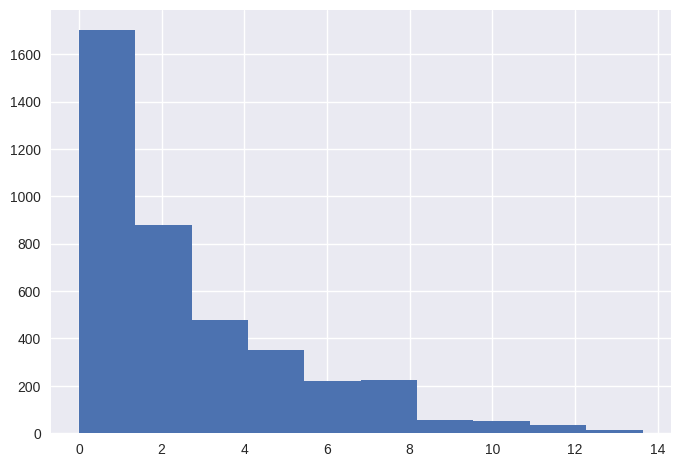

In [59]:
user_subscription_duration['occurred_at_time'].hist()#.head(10)

### SOC and SOH with total mileage (battery power consumpsion by bike as it ages)

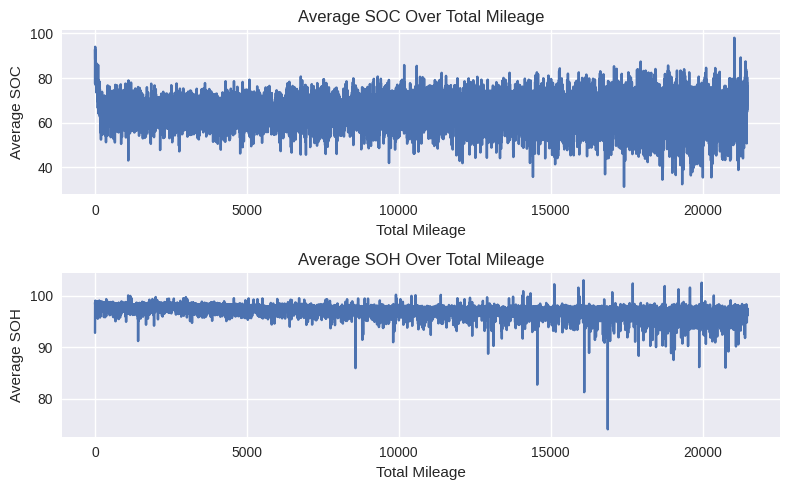

In [60]:
# Sort data by 'vehicle_id' and 'occurred_at_time'
df_sorted = df8.sort_values(by=['vehicle_id', 'occurred_at_time'])

# Calculate average SOC and SOH for each total_mileage
average_battery_stats = df_sorted.groupby('total_mileage').agg({
    'battery_state_battery_soc': 'mean',
    'battery_state_battery_soh': 'mean'
}).reset_index()

# Plotting the average SOC and SOH over total_mileage
plt.figure(figsize=(8, 5))

# Plot for SOC
plt.subplot(2, 1, 1)
sns.lineplot(x='total_mileage', y='battery_state_battery_soc', data=average_battery_stats)
plt.title('Average SOC Over Total Mileage')
plt.xlabel('Total Mileage')
plt.ylabel('Average SOC')

# Plot for SOH
plt.subplot(2, 1, 2)
sns.lineplot(x='total_mileage', y='battery_state_battery_soh', data=average_battery_stats)
plt.title('Average SOH Over Total Mileage')
plt.xlabel('Total Mileage')
plt.ylabel('Average SOH')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


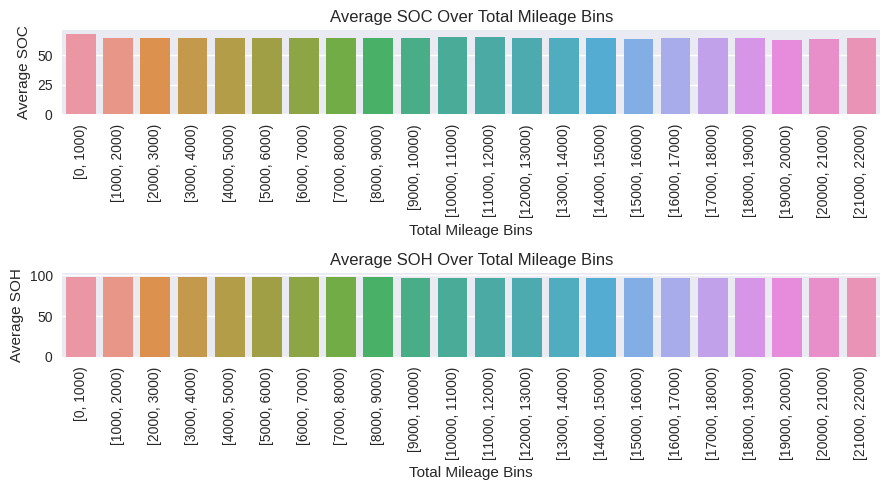

In [61]:
# Sort data by 'vehicle_id' and 'occurred_at_time'
df_sorted = df8.sort_values(by=['vehicle_id', 'occurred_at_time'])

# Create bins for 'total_mileage'
max_mileage = int(df_sorted['total_mileage'].max())
bins = list(range(0, max_mileage + 1000, 1000))

# Assign 'mileage_bin' based on 'total_mileage'
df_sorted['mileage_bin'] = pd.cut(df_sorted['total_mileage'], bins=bins, right=False)

# Calculate average SOC and SOH for each mileage_bin
average_battery_stats = df_sorted.groupby('mileage_bin').agg({
    'battery_state_battery_soc': 'mean',
    'battery_state_battery_soh': 'mean'
}).reset_index()

# Plotting the average SOC and SOH over mileage_bin
plt.figure(figsize=(9, 5))

# Plot for SOC
plt.subplot(2, 1, 1)
sns.barplot(x='mileage_bin', y='battery_state_battery_soc', data=average_battery_stats)
plt.title('Average SOC Over Total Mileage Bins')
plt.xlabel('Total Mileage Bins')
plt.ylabel('Average SOC')
plt.xticks(rotation=90)

# Plot for SOH
plt.subplot(2, 1, 2)
sns.barplot(x='mileage_bin', y='battery_state_battery_soh', data=average_battery_stats)
plt.title('Average SOH Over Total Mileage Bins')
plt.xlabel('Total Mileage Bins')
plt.ylabel('Average SOH')
plt.xticks(rotation=90)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


### battery usage with time and effect on SOC and SOH

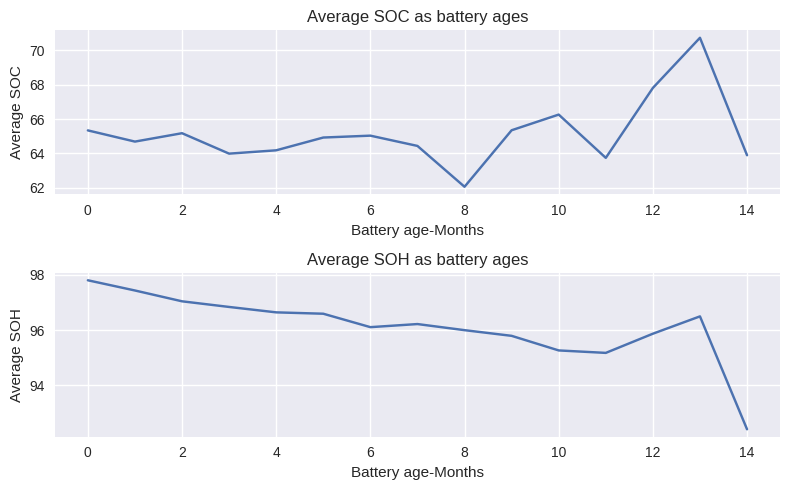

In [62]:
# Sort data by 'battery_serial_number' and 'occurred_at_time'
df_sorted = df8.sort_values(by=['battery_serial_number', 'occurred_at_time'])

# Calculate time in months for each record relative to the first record for each battery
df_sorted['months_since_start'] = abs((df_sorted.groupby('battery_serial_number')['occurred_at_time'].transform('min') - df_sorted['occurred_at_time']).dt.days) // 30

# Group by 'months_since_start' and calculate average SOC and SOH
average_battery_stats = df_sorted.groupby('months_since_start').agg({
    'battery_state_battery_soc': 'mean',
    'battery_state_battery_soh': 'mean'
}).reset_index()

# Plotting the average SOC and SOH over time
plt.figure(figsize=(8, 5))

# Plot for SOC
plt.subplot(2, 1, 1)
sns.lineplot(x='months_since_start', y='battery_state_battery_soc', data=average_battery_stats)
plt.title('Average SOC as battery ages')
plt.xlabel('Battery age-Months')
plt.ylabel('Average SOC')

# Plot for SOH
plt.subplot(2, 1, 2)
sns.lineplot(x='months_since_start', y='battery_state_battery_soh', data=average_battery_stats)
plt.title('Average SOH as battery ages')
plt.xlabel('Battery age-Months')
plt.ylabel('Average SOH')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


### SOC and SOH with seasons winter/summer (due to ambient temperature)

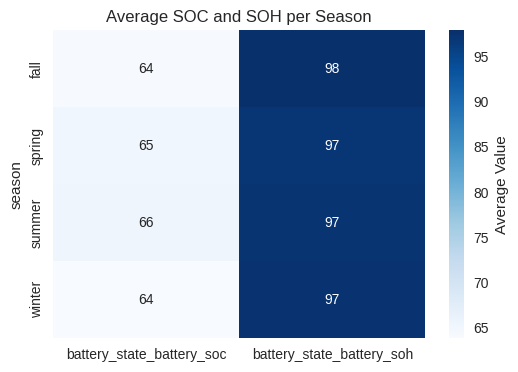

In [63]:
# Create a pivot table for average SOC and SOH per season
pivot_table_soc = df8.pivot_table(values='battery_state_battery_soc', index='season', aggfunc='mean')
pivot_table_soh = df8.pivot_table(values='battery_state_battery_soh', index='season', aggfunc='mean')

# Combine the pivot tables into a single DataFrame
combined_pivot = pd.concat([pivot_table_soc, pivot_table_soh], axis=1)#, keys=['SOC', 'SOH'])

# Plotting a heatmap for average SOC and SOH per season
plt.figure(figsize=(6, 4))
sns.heatmap(combined_pivot, annot=True, cmap='Blues', cbar_kws={'label': 'Average Value'})
plt.title('Average SOC and SOH per Season')
plt.show()


## anything else interesting you could think of

<ipython-input-64-0e281bc8b274>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  veh=df8[df_sorted['battery_serial_number_clean']==battery][:100]


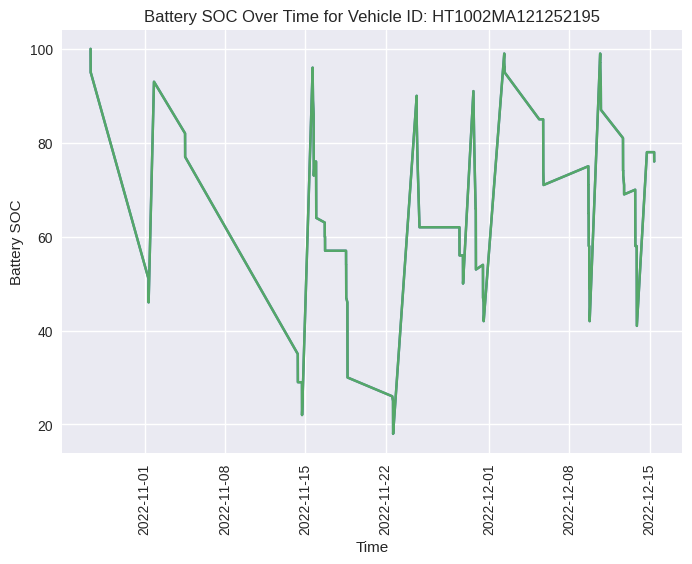

In [64]:
battery= random.choice(df8['battery_serial_number_clean'].unique())
df_sorted = df8.sort_values(by=['battery_serial_number_clean', 'occurred_at_time'])
veh=df8[df_sorted['battery_serial_number_clean']==battery][:100]
plt.plot(veh['occurred_at_time'],veh['battery_state_battery_soc'])
plt.plot(veh['occurred_at_time'], veh['battery_state_battery_soc'])
plt.title(f'Battery SOC Over Time for Vehicle ID: {battery}')
plt.xlabel('Time')
plt.ylabel('Battery SOC')
plt.xticks(rotation=90)
plt.show()

<ipython-input-65-df8834231869>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  veh=df8[df_sorted['battery_serial_number_clean']==battery]#[:100]


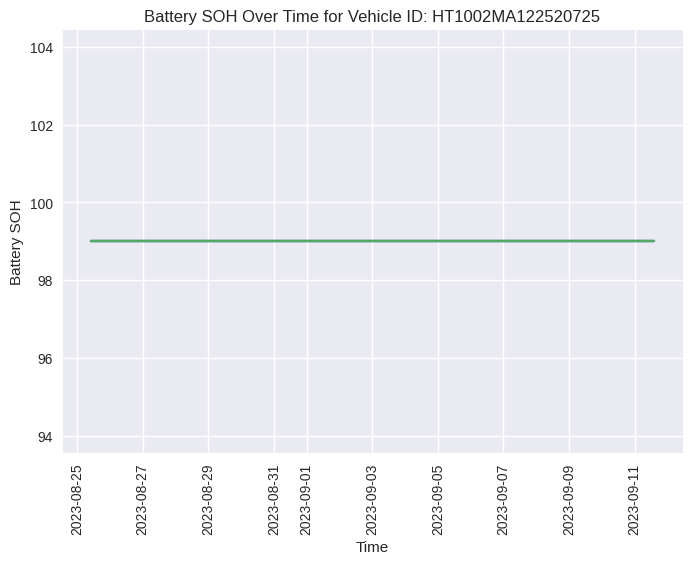

In [65]:
battery= random.choice(df8['battery_serial_number_clean'].unique())
df_sorted = df8.sort_values(by=['battery_serial_number_clean', 'occurred_at_time'])
veh=df8[df_sorted['battery_serial_number_clean']==battery]#[:100]
plt.plot(veh['occurred_at_time'],veh['battery_state_battery_soh'])
plt.plot(veh['occurred_at_time'], veh['battery_state_battery_soh'])
plt.title(f'Battery SOH Over Time for Vehicle ID: {battery}')
plt.xlabel('Time')
plt.ylabel('Battery SOH')
plt.xticks(rotation=90)
plt.show()